# Large Size Image 이미지 처리 : AutoEncoder = Encoder + Decoder 

제공된 데이터는 (해빙농도, 북극점, 해안선, 육지, 결측값) 5개 채널로 이루어져 있고, 각 채널의 사이즈는 (448,304)로 2차원으로 이미지 데이터로 생각할 수 있다. 해빙농도 값인 첫번째 채널 데이터에 대해 차원 변환 없이 Colab에서 ConvLSTM2D 모델링 학습을 시도하였으나, `ResourceExhaustedError`가 발생했다. 이미지 데이터 자체가 너무 크기 때문에 Colab에서 제공하는 GPU의 계산량을 감당할 수 없었던 것이다. 그동안 큰 사이즈의 이미지를 다루어 본 적이 없어서, 이미지 resize 방법만 고민하다가 AutoEncoder 에 대해 알게 되었다. Encoder로 압축한 데이터를 Decoder로 압축 데이터를 압축해제 하는 방식이다. 가지고 있는 Resource가 넉넉하지 않을 경우 큰 사이즈의 이미지를 분할하지 않고 처리하기 위해선 AutoEncoder 방식을 사용하는 것이 불가피해 보인다. 

Encoder : 고차원의 입력 데이터를 저차원의 표현 벡터로 압축    
Decoder : 표현 벡터를 고차원의 데이터로 압축 해제    


epochs = 1로 학습한 결과 경계 정도의 이미지를 생성해낼 수 있었으나 epochs = 100으로 실행할 경우 실제와 거의 동일한 이미지가 생성되는 것을 알 수 있다. 


참고 자료 : https://jamm-notnull.tistory.com/5


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import time 
import datetime


import tensorflow as tf 
import keras 
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose,Reshape
from keras.layers import Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Model
from keras import backend as K 
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error as mse 

tf.config.run_functions_eagerly(True)

warning.filterwanings('ignore')

In [15]:
# 제공된 데이터 파일을 하나의 파일로 저장됨. 
data = np.load('data/total_data.npy')     

In [16]:
data.shape

(482, 448, 304, 5)

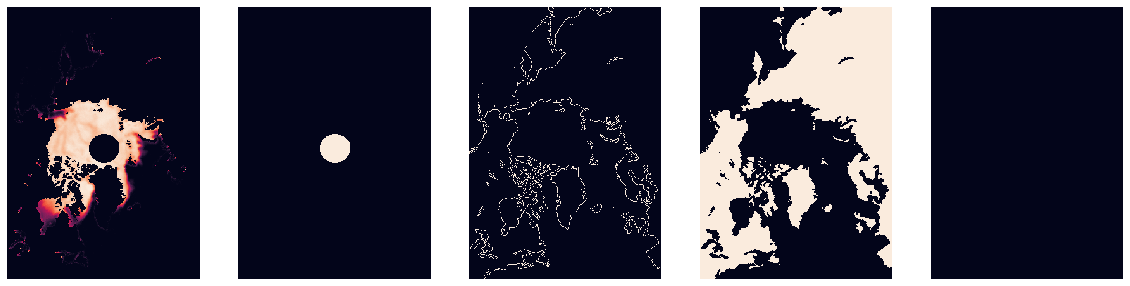

In [96]:
fig, axes =plt.subplots(figsize = (4*5,5), nrows = 1, ncols = 5)

for idx, ax in enumerate(axes.flat):
    sns.heatmap(data[0][:,:,idx], ax = ax , cbar = False,
               yticklabels = False, xticklabels = False)

In [17]:
# 해빙 농도 

ice_con = data[...,0]
ice_con.shape

(482, 448, 304)

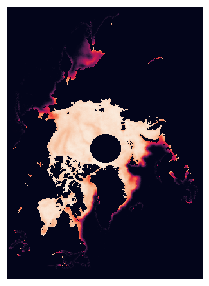

In [99]:
plt.figure(figsize = (3.5,5))
sns.heatmap(ice_con[1], cbar =False, 
            yticklabels = False, xticklabels = False)

In [24]:
print(ice_con.min(), ice_con.max())

0 250


In [18]:
# 해빙농도는 0~250으로 이루어져 있음. 
ice_con_250 = ice_con/250

ice_con_250 = ice_con_250.reshape(len(ice_con_250), 448, 304, 1)
ice_con_250.shape

(482, 448, 304, 1)

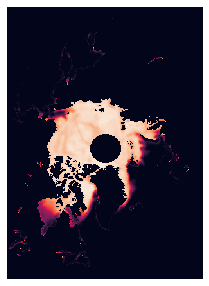

In [100]:
plt.figure(figsize = (3.5,5))
sns.heatmap(ice_con_250[0][:,:,0], cbar = False, 
            yticklabels = False, xticklabels = False)

## Encoder 모델 

In [45]:
encoder_input = Input(shape = (448, 304, 1))

x = Conv2D(filters = 4, kernel_size = 3, strides = 1, padding = "same")(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
shape_before_flatten = K.int_shape(x)[1:]

x = Flatten()(x)
encoder_output = Dense(units = 2)(x) # 2차원 잠재 공간으로 매핑 

In [46]:
model_encoder = Model(encoder_input, encoder_output)
model_encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization_6 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 544768)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1089538   
Total params: 1,089,594
Trainable params: 1,089,586
Non-trainable params: 8
_________________________________________________

In [47]:
shape_before_flatten

(448, 304, 4)

# Decoder 모델 

In [48]:
decoder_input = Input(shape = (2,)) # encoder output shape

x = Dense(units = np.prod(shape_before_flatten))(decoder_input)
x = Reshape(shape_before_flatten)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, padding ='same')(x)
x = Activation('sigmoid')(x)

decoder_output = x 

In [49]:
model_decoder = Model(decoder_input, decoder_output)
model_decoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 544768)            1634304   
_________________________________________________________________
reshape_4 (Reshape)          (None, 448, 304, 4)       0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 448, 304, 1)       37        
_________________________________________________________________
activation_1 (Activation)    (None, 448, 304, 1)       0   

# Encoder <-> Decoder 

In [50]:
model_input = encoder_input
model_output = model_decoder(encoder_output)

AutoEncoder = Model(model_input, model_output)

In [51]:
AutoEncoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization_6 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 544768)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1089538   
_________________________________________________________________
model_6 (Functional)         (None, 448, 304, 1)       1634

# AutoEncoder 학습 & 새로운 이미지 생성

학습 시 `ValueError: Creating variables on a non-first call to a function decorated with tf.function.` 가 발생할 경우,    
`tf.config.run_functions_eagerly(True)`을 실행하면 문제를 해결할 수 있음. 


In [52]:
optimizer = Adam(lr = 0.001) # 학습률 
AutoEncoder.compile(optimizer = optimizer,
                   loss = 'mean_squared_error')

In [ ]:
AutoEncoder.fit(ice_con_250, # data
                ice_con_250, # target data 
               batch_size = 10, shuffle =True, epochs = 1)

In [54]:
pred_ice_con = AutoEncoder.predict(ice_con_250)

In [55]:
print(ice_con_250.shape, pred_ice_con.shape)

(482, 448, 304, 1) (482, 448, 304, 1)


## 실제 해빙농도이미지와 AutoEncoder로 생성한 해빙농도이미지 비교 

epochs = 1로 하여 학습시킨 Base모델에서도 기본적인 구조에 대한 정보를 유지하는 것을 알 수 있음. 

In [28]:
# 한글 깨짐 해결 
from matplotlib import rc
rc('font', family='NanumMyeongjo')
plt.rcParams['axes.unicode_minus'] = False

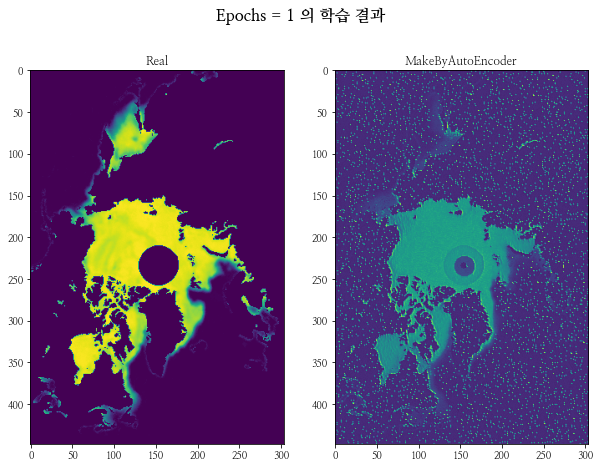

In [89]:
# 실제 해빙농도 이미지와 Auto
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

img1 = ice_con_250[2].reshape(448,304)
img2 = pred_ice_con[2].reshape(448,304)

ax1.imshow(img1)
ax1.set_title("Real")
ax2.imshow(img2)
ax2.set_title("MakeByAutoEncoder")
st = fig.suptitle('Epochs = 1 의 학습 결과', fontsize = 16, fontweight = 'bold')
st.set_y(0.85)
plt.show()


# epochs = 100 모델 학습 결과 확인 

In [91]:
start = time.time()
AutoEncoder.fit(ice_con_250, # data
                ice_con_250, # target data 
               batch_size = 10, shuffle =True, epochs = 100)

end = time.time() - start

Epoch 1/100
49/49 [==============================] - 51s 1s/step - loss: 0.0883
Epoch 2/100
49/49 [==============================] - 49s 1s/step - loss: 0.0553
Epoch 3/100
49/49 [==============================] - 53s 1s/step - loss: 0.0324
Epoch 4/100
49/49 [==============================] - 48s 978ms/step - loss: 0.0229
Epoch 5/100
49/49 [==============================] - 47s 950ms/step - loss: 0.0201
Epoch 6/100
49/49 [==============================] - 46s 941ms/step - loss: 0.0190
Epoch 7/100
49/49 [==============================] - 46s 946ms/step - loss: 0.0184
Epoch 8/100
49/49 [==============================] - 46s 945ms/step - loss: 0.0180
Epoch 9/100
49/49 [==============================] - 46s 946ms/step - loss: 0.0176
Epoch 10/100
49/49 [==============================] - 47s 950ms/step - loss: 0.0174
Epoch 11/100
49/49 [==============================] - 47s 951ms/step - loss: 0.0171
Epoch 12/100
49/49 [==============================] - 47s 953ms/step - loss: 0.0169
Epoch 13/1

In [92]:
print('epochs = 100의 AutoEncoder 모델 학습 시간 : ', str(datetime.timedelta(seconds = end)).split('.'))

epochs = 100의 AutoEncoder 모델 학습 시간 :  ['1:22:28', '399751']


In [93]:
pred_ice_con = AutoEncoder.predict(ice_con_250)

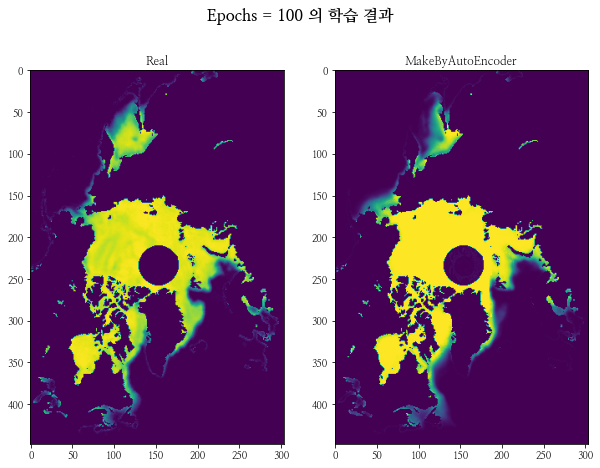

In [95]:
# 실제 해빙농도 이미지와 Auto
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

img1 = ice_con_250[2].reshape(448,304)
img2 = pred_ice_con[2].reshape(448,304)

ax1.imshow(img1)
ax1.set_title("Real")
ax2.imshow(img2)
ax2.set_title("MakeByAutoEncoder")
st = fig.suptitle('Epochs = 100 의 학습 결과', fontsize = 16, fontweight = 'bold')
st.set_y(0.85)
plt.show()

## AutoEncoder : 2D -> 2D 

In [3]:
encoder_input = Input(shape = (448, 304, 1))

x = Conv2D(filters = 4, kernel_size = 3, strides = 1, padding = "same")(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
shape_before_flatten = K.int_shape(x)[1:]
x = Flatten()(x)
x = Dense(28*19)(x)
encoder_output = Reshape((28,19))(x)

In [4]:
model_encoder = Model(encoder_input, encoder_output)
model_encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization (BatchNo (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 448, 304, 4)       0         
_________________________________________________________________
flatten (Flatten)            (None, 544768)            0         
_________________________________________________________________
dense (Dense)                (None, 532)               289817108 
_________________________________________________________________
reshape (Reshape)            (None, 28, 19)            0     

In [5]:
shape_before_flatten

(448, 304, 4)

In [19]:
ice_con_250.shape

(482, 448, 304, 1)

In [10]:
decoder_input = Input(shape = (28,19)) # encoder output shape

x = Flatten()(decoder_input)
x = Dense(units = np.prod(shape_before_flatten))(x)
x = Reshape(shape_before_flatten)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, padding ='same')(x)
x = Activation('sigmoid')(x)

decoder_output = x 

In [11]:
decoder_output

<KerasTensor: shape=(None, 448, 304, 1) dtype=float32 (created by layer 'activation_1')>

In [12]:
model_decoder = Model(decoder_input, decoder_output)
model_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 19)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 532)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 544768)            290361344 
_________________________________________________________________
reshape_3 (Reshape)          (None, 448, 304, 4)       0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 448, 304, 1)       37  

In [20]:
model_input = encoder_input # 원 이미지 데이터 입력 
model_output = model_decoder(encoder_output)   # encoder 의 결과 데이터 입력 

AutoEncoder = Model(model_input, model_output) 

In [23]:
optimizer = Adam(lr = 0.001) # 학습률 
AutoEncoder.compile(optimizer = optimizer,
                   loss = 'mean_squared_error')

In [24]:
start = time.time()
AutoEncoder.fit(ice_con_250, # data
                ice_con_250, # target data 
               batch_size = 10, shuffle =True, epochs = 1)

end = time.time() - start

49/49 [==============================] - 8420s 174s/step - loss: 0.2260


In [25]:
print('outputshape 16배 축소 (28,19) shape 수행시간 : ', str(datetime.timedelta(seconds = end)).split('.'))

outputshape 16배 축소 (28,19) shape 수행시간 :  ['2:20:21', '749112']


In [26]:
pred_ice_con = AutoEncoder.predict(ice_con_250)

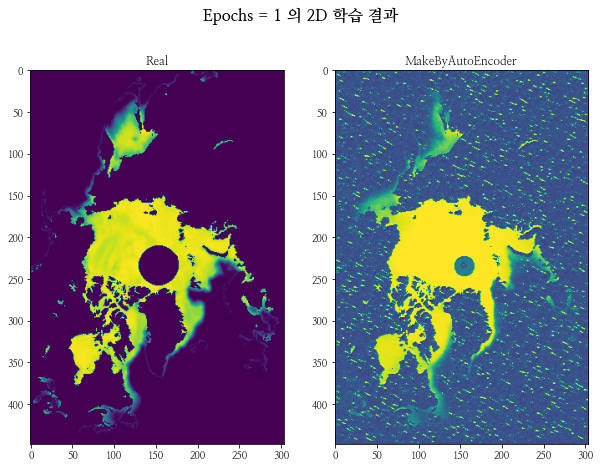

In [29]:
# 실제 해빙농도 이미지와 Auto
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

img1 = ice_con_250[2].reshape(448,304)
img2 = pred_ice_con[2].reshape(448,304)

ax1.imshow(img1)
ax1.set_title("Real")
ax2.imshow(img2)
ax2.set_title("MakeByAutoEncoder")
st = fig.suptitle('Epochs = 1 의 2D 학습 결과', fontsize = 16, fontweight = 'bold')
st.set_y(0.85)
plt.show()

epochs =1 일 때 encoder 마지막 layers에서 Dense(units = (2,)) 결과 대비 원본과 더 비슷한 이미지를 가지고 왔다. 다만 원본 사이즌인 (448,304)의 16배 축소한 (28,19)로 하였을 때 parameters의 총 개수가 2억 9천개가 넘어가는 바람에 epochs =1로 돌렸음에도 불구하고 학습하는데 2시간 이상이 소요되었다. (28,19) 보다 작은 사이즈로 축소해야 할 것 같다. 

In [30]:
def encoder(inputs, outputs):
    
    encoder_input = tf.keras.layers.Input(shape = inputs)
    x = tf.keras.layers.Conv2D(filters = 4, kernel_size = 3,
                              strides = 1, padding ='same')(encoder_input)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    shape_before_flatten = K.int_shape(x)[1:]
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(outputs[0]*outputs[1])(x)
    encoder_output = tf.keras.layers.Reshape(outputs)(x)
    
    return shape_before_flatten, encoder_input, encoder_output

In [40]:
def decoder(shape_before_flatten, outputs):
    decoder_input = tf.keras.layers.Input(shape = outputs) # encoder output shape

    x = tf.keras.layers.Flatten()(decoder_input)
    x = tf.keras.layers.Dense(units = np.prod(shape_before_flatten))(x)
    x = tf.keras.layers.Reshape(shape_before_flatten)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, padding ='same')(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    decoder_output = x 
    
    model_decoder = tf.keras.Model(decoder_input, decoder_output)
    
    return decoder_input, decoder_output, model_decoder

# Encoder의 output shape = (4,4)

In [60]:
inputs = (448, 304,1)
outputs = (4,4)
shape_before_flatten, encoder_input, encoder_output = encoder(inputs, outputs)

In [61]:
model = Model(encoder_input, encoder_output)

In [62]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization_8 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 544768)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                8716304   
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4)              0  

In [63]:
decoder_input, decoder_output, model_decoder = decoder(shape_before_flatten, outputs)

In [64]:
model_decoder = Model(decoder_input, decoder_output)
model_decoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 4, 4)]            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 544768)            9261056   
_________________________________________________________________
reshape_10 (Reshape)         (None, 448, 304, 4)       0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 448, 304, 1)       37 

In [65]:
model_input = encoder_input # 원 이미지 데이터 입력 
model_output = model_decoder(encoder_output)   # encoder 의 결과 데이터 입력 

AutoEncoder = Model(model_input, model_output) 

In [66]:
AutoEncoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization_8 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 544768)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                8716304   
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4)              0  

In [67]:
AutoEncoder.compile("Adam", loss = 'mean_squared_error')

In [68]:
start = time.time()
AutoEncoder.fit(ice_con_250, ice_con_250,
               batch_size = 10, shuffle =True, epochs = 1)
end = time.time() -start 

49/49 [==============================] - 50s 1s/step - loss: 0.2130


In [69]:
print('output shape (4,4) shape 수행시간 : ', str(datetime.timedelta(seconds = end)).split('.'))

output shape (4,4) shape 수행시간 :  ['0:00:50', '581738']


In [70]:
pred_ice_con = AutoEncoder.predict(ice_con_250)

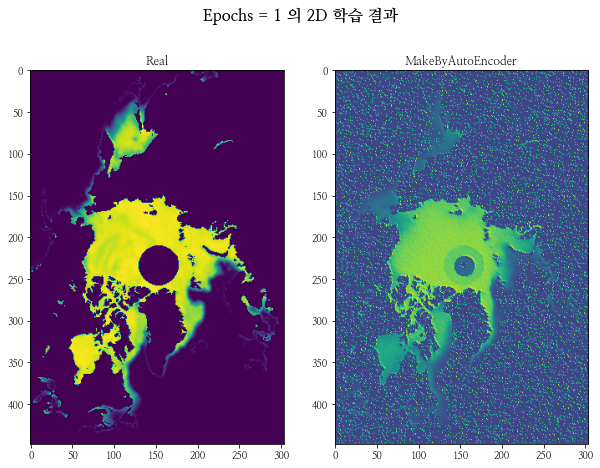

In [71]:
# 실제 해빙농도 이미지와 Auto
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

img1 = ice_con_250[2].reshape(448,304)
img2 = pred_ice_con[2].reshape(448,304)

ax1.imshow(img1)
ax1.set_title("Real")
ax2.imshow(img2)
ax2.set_title("MakeByAutoEncoder")
st = fig.suptitle('Epochs = 1 의 2D 학습 결과', fontsize = 16, fontweight = 'bold')
st.set_y(0.85)
plt.show()

# Encoder output shape = (8,8) 

In [75]:
inputs = (448, 304,1)
outputs = (8,8)
shape_before_flatten, encoder_input, encoder_output = encoder(inputs, outputs)
decoder_input, decoder_output, model_decoder = decoder(shape_before_flatten, outputs)

In [76]:
model_input = encoder_input # 원 이미지 데이터 입력 
model_output = model_decoder(encoder_output)   # encoder 의 결과 데이터 입력 

AutoEncoder = Model(model_input, model_output) 

In [77]:
AutoEncoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization_12 (Batc (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 448, 304, 4)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 544768)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                34865216  
_________________________________________________________________
reshape_13 (Reshape)         (None, 8, 8)              0  

In [78]:
AutoEncoder.compile("Adam", loss = 'mean_squared_error')

In [79]:
start = time.time()
AutoEncoder.fit(ice_con_250, ice_con_250,
               batch_size = 10, shuffle =True, epochs = 1)
end = time.time() -start 
print(f'output shape {outputs} shape 수행시간 : ', str(datetime.timedelta(seconds = end)).split('.'))

49/49 [==============================] - 65s 1s/step - loss: 0.2424
output shape (8, 8) shape 수행시간 :  ['0:01:05', '336733']


In [80]:
pred_ice_con = AutoEncoder.predict(ice_con_250)

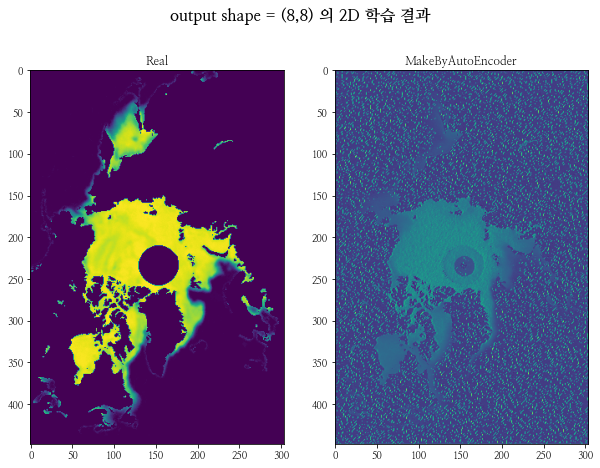

In [83]:
# 실제 해빙농도 이미지와 Auto
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

img1 = ice_con_250[2].reshape(448,304)
img2 = pred_ice_con[2].reshape(448,304)

ax1.imshow(img1)
ax1.set_title("Real")
ax2.imshow(img2)
ax2.set_title("MakeByAutoEncoder")
st = fig.suptitle('output shape = (8,8) 의 2D 학습 결과', fontsize = 16, fontweight = 'bold')
st.set_y(0.85)
plt.show()